In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

import h5py, os, scipy
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

from msfm.utils import power_spectra, files, scales
from deep_lss.utils import configuration
from msi.utils import input_output, preprocessing

In [3]:
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"

msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml")

dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_config.yaml"
dlss_conf = configuration.load_deep_lss_config(dlss_conf)

24-09-13 03:19:19 configuratio INF   Loaded the config 


In [4]:
l_mins, l_maxs = power_spectra.get_l_limits(msfm_conf)
print(l_mins)
print(l_maxs)

[30, 30, 30, 30, 30, 30, 30, 30]
[None, None, None, None, None, None, None, None]


# from binned file

[None]

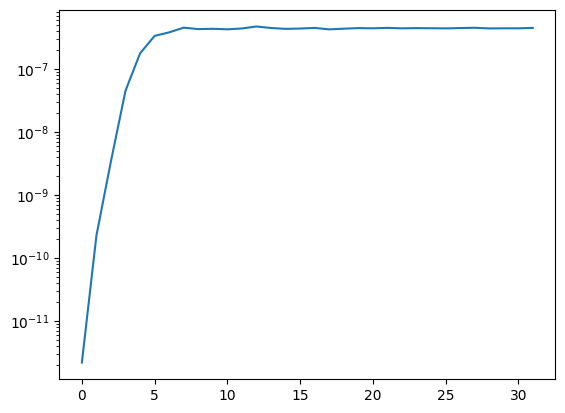

In [5]:
with h5py.File("/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/debug/white_noise_0000.h5", "r") as f:
    noise_cls_direct = f["cls/binned"][:]
    
fig, ax = plt.subplots()
ax.plot(noise_cls_direct[0,:32,0])
ax.set(yscale="log")

(100000, 32, 36)


[None]

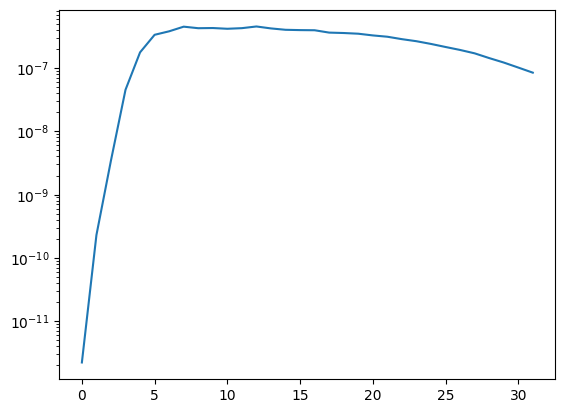

In [6]:
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"

noise_cls_file = input_output.load_cl_white_noise(base_dir)

print(noise_cls_file.shape)

fig, ax = plt.subplots()
ax.plot(noise_cls_file[0,:32,0])
ax.set(yscale="log")

24-09-13 03:21:10 preprocessin INF   Reading the smoothing scale from the DLSS configuration file 
24-09-13 03:21:10 preprocessin INF   Loading the pre-binned Cls 
24-09-13 03:21:10 input_output INF   Array shapes: 
24-09-13 03:21:10 input_output INF   fiducial/i_example = (35920,) 
24-09-13 03:21:10 input_output INF   fiducial/i_noise   = (35920,) 
24-09-13 03:21:10 input_output INF   fiducial/cls/binned = (35920, 32, 36) 
24-09-13 03:21:10 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-09-13 03:21:10 input_output INF   grid/cosmo         = (2500, 400, 12) 
24-09-13 03:21:10 input_output INF   grid/i_example     = (2500, 400) 
24-09-13 03:21:10 input_output INF   grid/i_noise       = (2500, 400) 
24-09-13 03:21:10 input_output INF   grid/i_sobol       = (2500, 400) 
24-09-13 03:21:12 input_output INF   grid/cls/binned    = (2500, 400, 32, 36) 
24-09-13 03:21:12 input_output INF   grid/cls/bin_edges = (2500, 33, 36) 
24-09-13 03:21:12 input_output INF   Done loading the summa

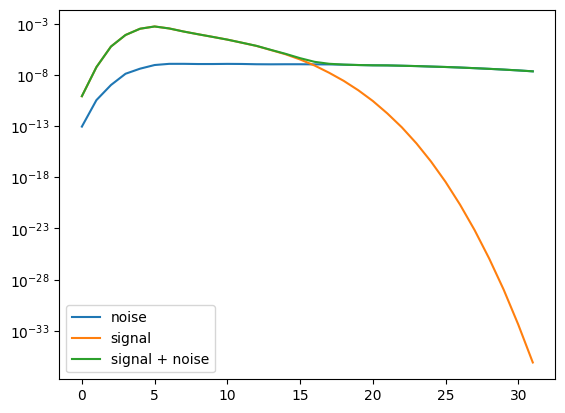

In [15]:
fidu_cls, grid_cls, noise_cls, grid_cosmos, grid_i_sobols, file_dict, scaler, pca = (
    preprocessing.get_reshaped_human_summaries(
        base_dir,
        "cls",
        file_label=None,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        concat_example_dim=False,
        do_plot=False,
        # selection
        with_lensing=False,
        with_clustering=True,
        with_cross_z=False,
        with_cross_probe=False,
        # power spectra: scales
        from_raw_cls=False,
        # unlike the standardization, the logarithm is not linear and has to be applied as log(signal + noise), not
        # log(signal) + log(noise)
        apply_log=False,
        standardize=False,
        pca_components=None,
    )
)

fig, ax = plt.subplots()
ax.plot(noise_cls[0,:32], label="noise")
ax.plot(fidu_cls[0,:32], label="signal")
ax.plot(fidu_cls[0,:32] + noise_cls[0,:32], label="signal + noise")
ax.set(yscale="log")
ax.legend()

[None, (1e-18, 1e-13)]

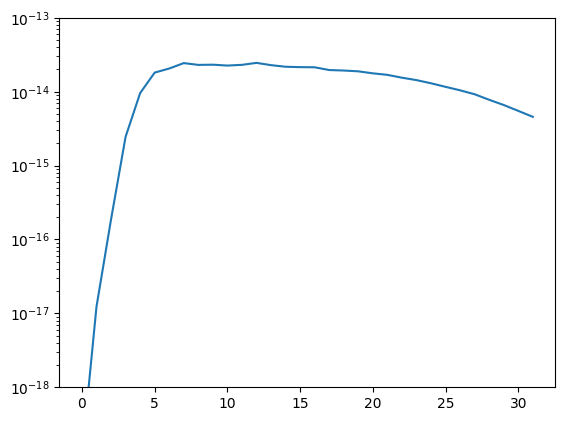

In [14]:
fig, ax = plt.subplots()
ax.plot(noise_cls[0,:32])
ax.set(yscale="log", ylim=(1e-18,1e-13))

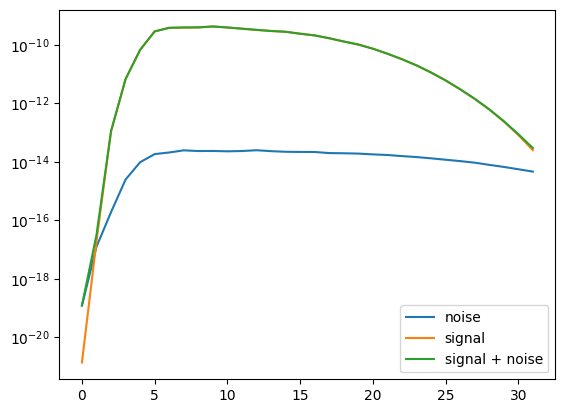

In [9]:
fig, ax = plt.subplots()
ax.plot(noise_cls[0,:32], label="noise")
ax.plot(fidu_cls[0,:32], label="signal")
ax.plot(fidu_cls[0,:32] + noise_cls[0,:32], label="signal + noise")
ax.set(yscale="log")
ax.legend()

# from map

In [10]:
n_side = msfm_conf["analysis"]["n_side"]
n_pix = msfm_conf["analysis"]["n_pix"]
data_vec_pix, patches_pix_dict, _, _ = files.load_pixel_file(msfm_conf)
patches_pix = patches_pix_dict["metacal"][0][0]

24-09-13 03:19:36     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


[None, (1e-18, 1e-13)]

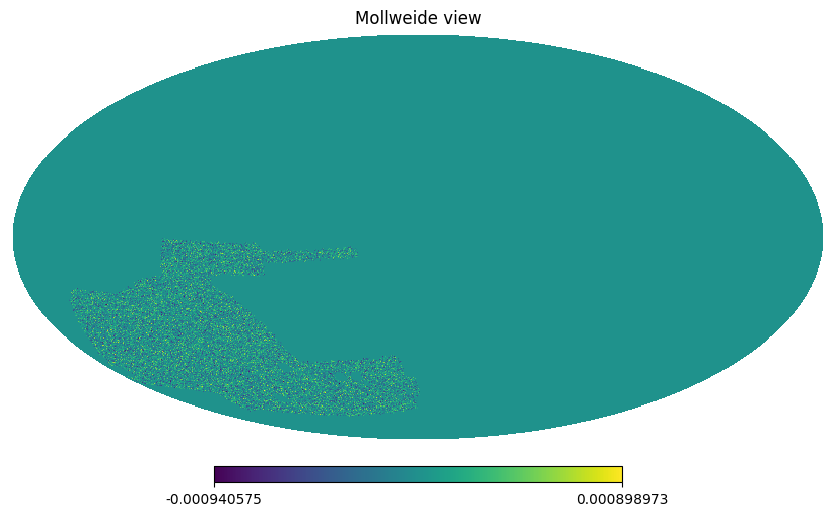

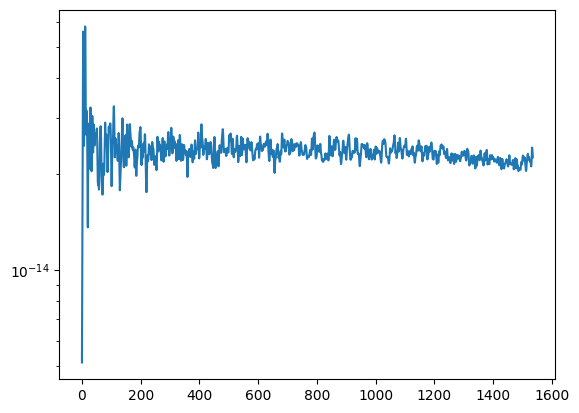

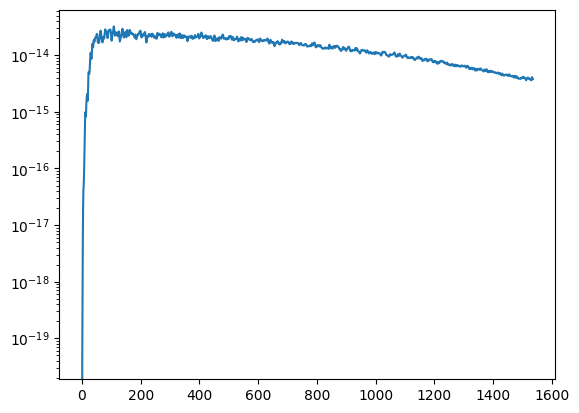

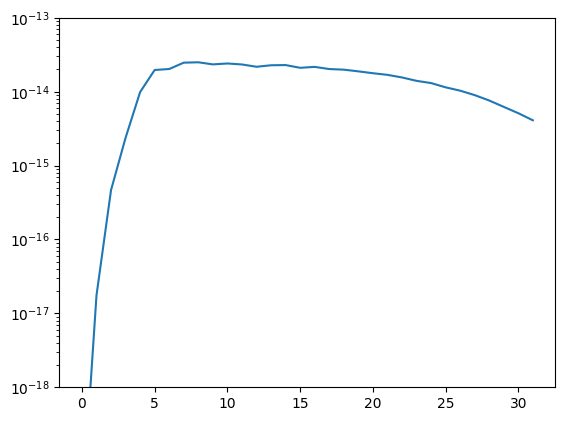

In [11]:
rng = np.random.default_rng()
sigma = dlss_conf["scale_cuts"]["lensing"]["white_noise_sigma"][0]

noise_map = np.zeros(n_pix)
noise_map[patches_pix] = rng.normal(loc=0.0, scale=sigma, size=patches_pix.shape[0])

hp.mollview(noise_map)

noise_cls = hp.anafast(noise_map)

fig, ax = plt.subplots()
ax.plot(noise_cls)
ax.set(yscale="log")

# power_spectra.bin_according_to_config(noise_cls[np.newaxis], msfm_conf)
# noise_cls_binned = np.squeeze(noise_cls_binned)


ells = np.arange(3 * n_side)

noise_cls = scales.cls_to_smoothed_cls(
    noise_cls, 
    l_min=msfm_conf["analysis"]["scale_cuts"]["lensing"]["l_min"][0], 
    # l_max=msfm_conf["analysis"]["scale_cuts"]["lensing"]["l_max"],
    l_max=1535,
    theta_fwhm=msfm_conf["analysis"]["scale_cuts"]["lensing"]["theta_fwhm"],
)

fig, ax = plt.subplots()
ax.plot(noise_cls)
ax.set(yscale="log")

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
noise_cls_binned = binned_statistic(ells, noise_cls, statistic="mean", bins=bins)[0]

fig, ax = plt.subplots()
ax.plot(noise_cls_binned)
ax.set(yscale="log", ylim=(1e-18,1e-13))